In [1]:

!pip install optree


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Found 10036 images belonging to 5 classes.
Found 2507 images belonging to 5 classes.


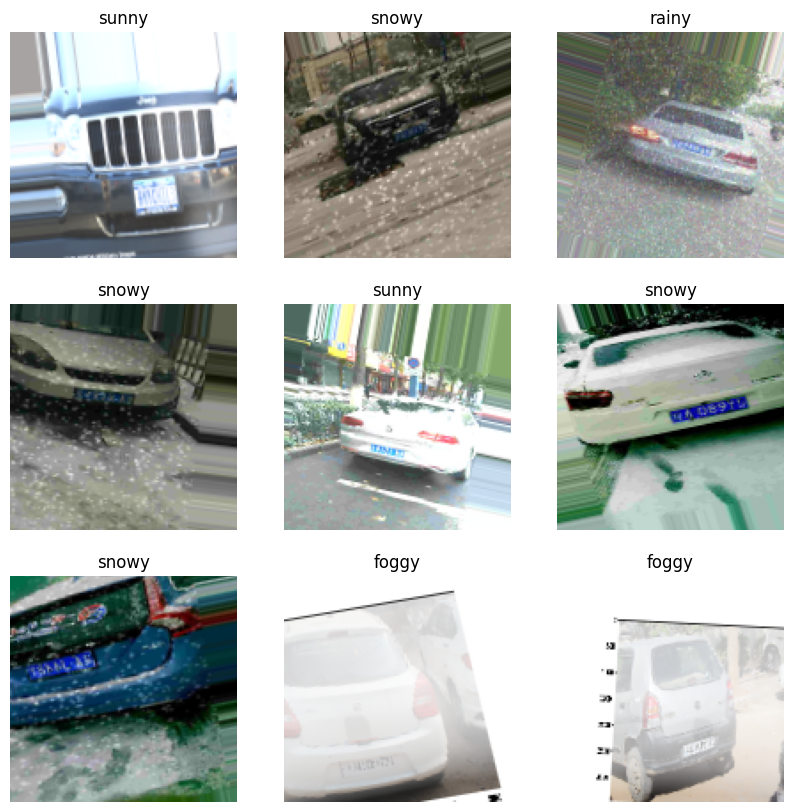

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define image dimensions and batch size
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# 🟢 Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,   # Normalization
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Splitting dataset
)

# Load Training Data
train_data = datagen.flow_from_directory(
    './Downloads/fypdataset/fypdataset',  
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',  # Training split
    seed=42
)

# Load Validation Data
val_data = datagen.flow_from_directory(
    './Downloads/fypdataset/fypdataset',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',  # Validation split
    seed=42
)

# Display Sample Images
class_names = list(train_data.class_indices.keys())
images, labels = next(train_data)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")
plt.show()

# Callbacks for Training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)


In [6]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback

# 🟢 Load Pretrained ResNet50 (With ImageNet Weights)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Initially freeze all layers

# 🟢 Custom Classification Head
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(256, kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

x = Dense(128, kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

output = Dense(5, activation='softmax')(x)  # 5-class classification

# 🟢 Define Model
model = Model(inputs=base_model.input, outputs=output)

# 🟢 Learning Rate Schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,  # Start with 0.0001
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=lr_schedule, clipnorm=1.0)  
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# 🟢 Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True, mode='min')

# 🟢 Progressive Fine-Tuning Callback
def unfreeze_model():
    base_model.trainable = True  # Unfreeze base model
    for layer in base_model.layers[:100]:  # Train last 100 layers
        layer.trainable = True
    print("Unfreezing ResNet50 layers for fine-tuning.")

fine_tune_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: unfreeze_model() if epoch == 5 else None
)


# 🟢 Print Model Summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 134, 134, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 64, 64, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 64, 64, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 64, 64, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 66, 66, 64)        │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 32, 32, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 32, 32, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 32, 32, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 32, 32, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 32, 32, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 32, 32, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 32, 32, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 24,147,333 (92.11 MB)

 Trainable params: 558,853 (2.13 MB)

 Non-trainable params: 23,588,480 (89.98 MB)

In [7]:


# Train the model
epochs = 10
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=val_data,
    callbacks=[early_stopping]
)
# Save the model
model.save("weather_classifier.keras")

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 625s 2s/step - accuracy: 0.3807 - loss: 1.6329 - val_accuracy: 0.3893 - val_loss: 1.4454
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 461s 1s/step - accuracy: 0.6678 - loss: 0.8759 - val_accuracy: 0.5888 - val_loss: 0.9652
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 456s 1s/step - accuracy: 0.7051 - loss: 0.7587 - val_accuracy: 0.7583 - val_loss: 0.6816
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 456s 1s/step - accuracy: 0.7470 - loss: 0.6623 - val_accuracy: 0.7272 - val_loss: 0.7124
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 460s 1s/step - accuracy: 0.7607 - loss: 0.6357 - val_accuracy: 0.6693 - val_loss: 0.8673
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 454s 1s/step - accuracy: 0.7667 - loss: 0.6122 - val_accuracy: 0.7020 - val_loss: 0.8039


AttributeError: module 'matplotlib' has no attribute 'figure'

In [29]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_data)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


79/79 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8397 - loss: 0.4773
Validation Loss: 0.4894316494464874
Validation Accuracy: 0.8336657285690308


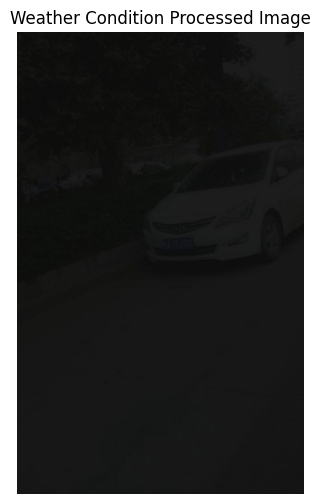

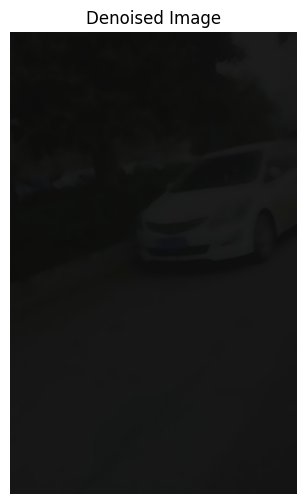

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the trained model
model_path = "weather_classifier.keras"
model = load_model(model_path)

# Function to apply preprocessing based on weather condition
def preprocess_image_based_on_condition(img_path, weather_condition):
    img = cv2.imread(img_path)
    
    if weather_condition == "foggy":
        img = dehaze_image(img)
    elif weather_condition == "rainy":
        img = remove_rain_streaks(img)
    elif weather_condition == "lowlight":
        img = enhance_low_light(img)
    elif weather_condition == "snowy":
        img = adjust_brightness(img)

    return img

# Function to apply denoising
def denoise_image(img):
    return cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

# Function to display images using Matplotlib
def display_image(img, title="Processed Image"):
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
    plt.title(title)
    plt.axis("off")
    plt.show()

# Implemented Dehazing using Dark Channel Prior
def dehaze_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    dark_channel = cv2.min(cv2.erode(gray, np.ones((15, 15), np.uint8)), gray)
    transmission = 1 - 0.95 * (dark_channel / 255.0)
    transmission = np.clip(transmission, 0.1, 1)
    img = img / np.expand_dims(transmission, axis=2)
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

# Implemented Rain Streak Removal using Guided Filtering
def remove_rain_streaks(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    denoised = cv2.fastNlMeansDenoising(gray, None, 30, 7, 21)
    img[:, :, 0] = denoised
    img[:, :, 1] = denoised
    img[:, :, 2] = denoised
    return img

# Function for Low-Light Enhancement
def enhance_low_light(img):
    return cv2.convertScaleAbs(img, alpha=1.5, beta=20)

# Function for Snowy Condition Brightness Adjustment
def adjust_brightness(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l = cv2.equalizeHist(l)
    img = cv2.merge((l, a, b))
    img = cv2.cvtColor(img, cv2.COLOR_LAB2BGR)
    return img

# Path to the input image
img_path = "Downloads/fypdataset/fypdataset/low_light/00205459770115-90_85-352,516_448,547-444,547_368,549_364,517_440,515-0_0_22_10_26_29_24-128-7.jpg"
weather_condition = "foggy"  # Manually specify the weather condition

# Preprocess the image based on the given weather condition
processed_image = preprocess_image_based_on_condition(img_path, weather_condition)

# Apply denoising to the processed image
denoised_image = denoise_image(processed_image)

# Display the images
display_image(processed_image, title="Weather Condition Processed Image")
display_image(denoised_image, title="Denoised Image")
